# Version 4 Notes: 
* This is Ash's implementation
* Training = augmented
* Validatoin = augmented dataset

* ##### Issues: 
* Evaluation is being done on validation set instead of a new unseen testing set, so results might be too optimistic

In [31]:
! pip install tensorflow
! pip install kagglehub
! pip install psutil
! pip install matplotlib
%pip install scikit-learn
%pip install imbalanced-learn
! pip install pandas


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [32]:
import os
import warnings
warnings.filterwarnings("ignore")

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from pathlib import Path
import os.path

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier



# Setting Paths

In [35]:
# importing the data
import kagglehub

# download latest version
path = kagglehub.dataset_download("uraninjo/augmented-alzheimer-mri-dataset") # directory path

print("Path to dataset files:", path)

base_path = path  # this path comes from the API

train_dir = os.path.join(base_path, 'AugmentedAlzheimerDataset') # subdirectory (AugmentedAlzheimerDataset) inside the base path

# printing the directories to verify
print("Train Directory:", train_dir) # path to the training directory

Path to dataset files: /home/gitpod/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1
Train Directory: /home/gitpod/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1/AugmentedAlzheimerDataset


In [36]:
image_dir = Path(train_dir)

# get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) # list contains all image file paths in the directory

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths)) # list will now contain labels for each image file, based on the directory names

filepaths = pd.Series(filepaths, name='Filepath').astype(str)  # converted into a Pandas Series  and cast to string type to ensure compatibility when working with the DataFrame
labels = pd.Series(labels, name='Label') # also converted into a Pandas series

# concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1) # pd.concat() concatenates the filepaths and labels Series along the column axis to create a DataFrame named image_df.

In [37]:
# identify and print out the paths of any .jpg images within base_path that cannot be opened due to being unrecognized or corrupted.
# For quality-checking the dataset and ensuring all images are valid before processing them
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(base_path).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

In [38]:
image_df

,Filepath,Label
0,/home/gitpod/.cache/kagglehub/datasets/uraninj...,MildDemented
1,/home/gitpod/.cache/kagglehub/datasets/uraninj...,MildDemented
2,/home/gitpod/.cache/kagglehub/datasets/uraninj...,MildDemented
3,/home/gitpod/.cache/kagglehub/datasets/uraninj...,MildDemented
4,/home/gitpod/.cache/kagglehub/datasets/uraninj...,MildDemented
...,...,...
33979,/home/gitpod/.cache/kagglehub/datasets/uraninj...,VeryMildDemented
33980,/home/gitpod/.cache/kagglehub/datasets/uraninj...,VeryMildDemented
33981,/home/gitpod/.cache/kagglehub/datasets/uraninj...,VeryMildDemented
33982,/home/gitpod/.cache/kagglehub/datasets/uraninj...,VeryMildDemented


In [39]:
image_df.shape

(33984, 2)

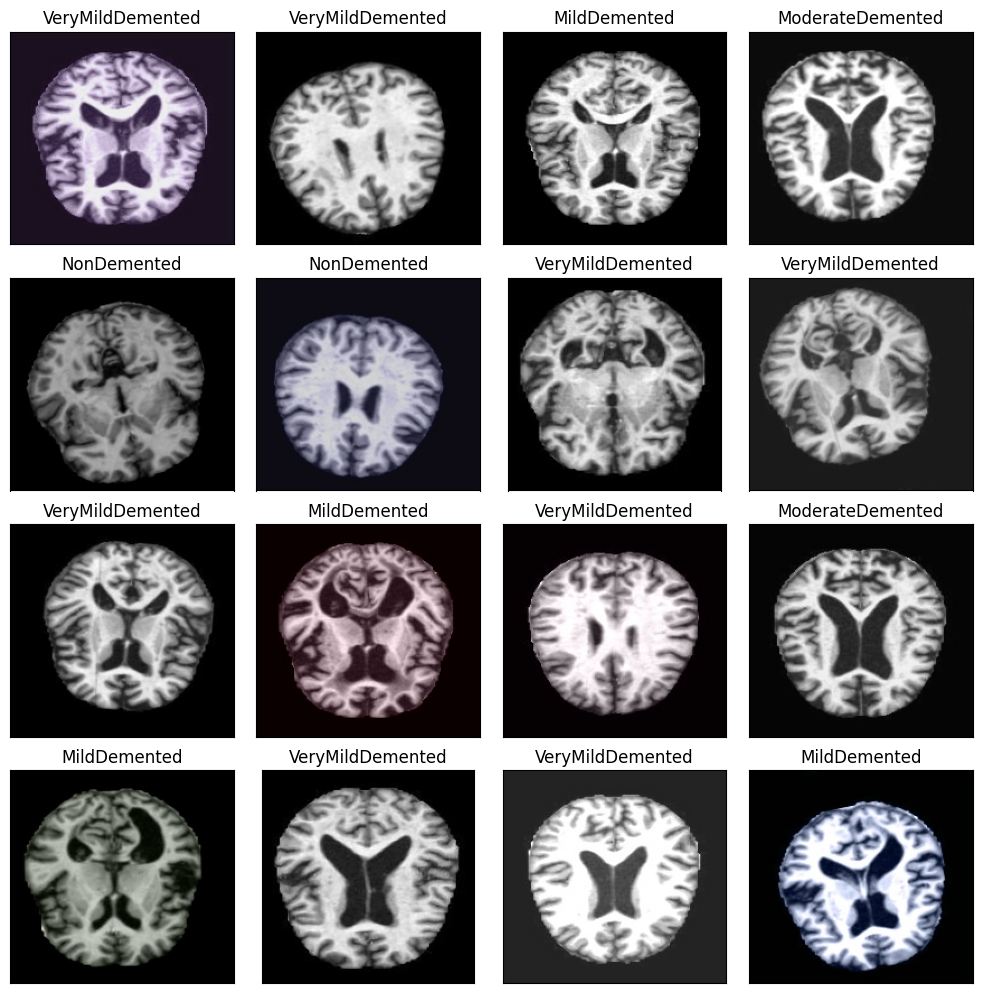

In [40]:
#  randomly select 16 images from image_df and displays them in a 4x4 grid with their labels as titles.
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# Rescaling, Resizing, and Train/Test/Validation Splits

In [ ]:
# sets up two data generators, one for training and one for validation, which will load, resize, and preprocess images from the  directory (train_dir).
# The images are rescaled, organized into batches, and split into training and validation sets to be used in model training.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# generates batches of image data with real-time data augmentation. It allows the images to be loaded and preprocessed in real-time

train_datagen = ImageDataGenerator(rescale=1./255,
    validation_split=0.3) # set validation

train_images = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), # resizes each image to 224x224 pixels
    batch_size=32, # the generator will yield batches of 32 images at a time
    class_mode='categorical', # labels are categorical, meaning the generator will one-hot encode the labels.
    subset='training', # specifies that this generator will use the 80% subset for training
    shuffle = True) # shuffle the dataset to promote model generalization

validation_images = train_datagen.flow_from_directory(
    train_dir ,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation', # specified to use the 20% of the images allocated for validation
    shuffle = False) # do no shuffle to keep consistent evaluation order

Found 27188 images belonging to 4 classes.
Found 6796 images belonging to 4 classes.


In [42]:
true_classes = validation_images.classes

In [43]:
print(len(train_images))
print(len(validation_images))

850
213


# Dictionary to store histories and evaluation metrics

In [44]:
# Dictionary to store histories and evaluation metrics
histories = {}
evaluation_metrics = {}

# Model 1: Basic CNN

In [45]:
# Model 1: Basic CNN
print("\nTraining Model 1: Basic CNN")
model_1 = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(4, activation='softmax')
])
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_1 = model_1.fit(train_images, validation_data=validation_images, epochs=10)
histories['Model 1'] = history_1


Training Model 1: Basic CNN
Epoch 1/10


850/850 ━━━━━━━━━━━━━━━━━━━━ 473s 553ms/step - accuracy: 0.5220 - loss: 1.0126 - val_accuracy: 0.7612 - val_loss: 0.5727
Epoch 2/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 463s 545ms/step - accuracy: 0.7906 - loss: 0.4938 - val_accuracy: 0.8589 - val_loss: 0.3359
Epoch 3/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 653s 768ms/step - accuracy: 0.8802 - loss: 0.2884 - val_accuracy: 0.8689 - val_loss: 0.3243
Epoch 4/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 531s 625ms/step - accuracy: 0.9219 - loss: 0.1954 - val_accuracy: 0.8943 - val_loss: 0.2642
Epoch 5/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 528s 621ms/step - accuracy: 0.9480 - loss: 0.1320 - val_accuracy: 0.9010 - val_loss: 0.2605
Epoch 6/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 553s 651ms/step - accuracy: 0.9605 - loss: 0.1042 - val_accuracy: 0.8899 - val_loss: 0.3769
Epoch 7/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 541s 637ms/step - accuracy: 0.9673 - loss: 0.0877 - val_accuracy: 0.9063 - val_loss: 0.2952
Epoch 8/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 461s 543ms/step - accuracy: 0.9768 - loss: 0.06


Evaluating Model 1
213/213 ━━━━━━━━━━━━━━━━━━━━ 31s 144ms/step


<Figure size 800x800 with 0 Axes>

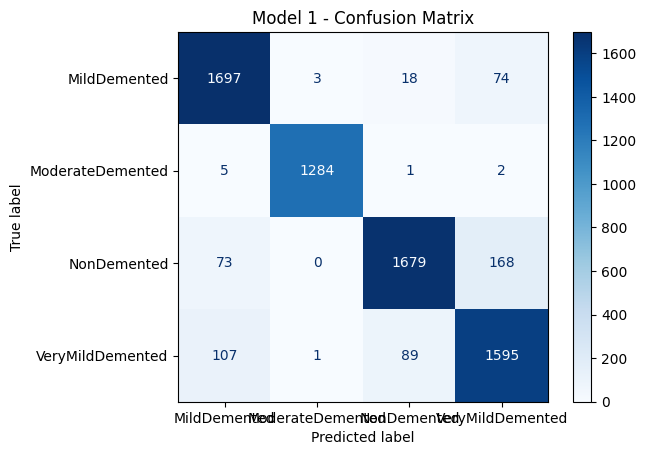

Model 1 - Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.90      0.95      0.92      1792
ModerateDemented       1.00      0.99      1.00      1292
     NonDemented       0.94      0.87      0.91      1920
VeryMildDemented       0.87      0.89      0.88      1792

        accuracy                           0.92      6796
       macro avg       0.93      0.93      0.93      6796
    weighted avg       0.92      0.92      0.92      6796



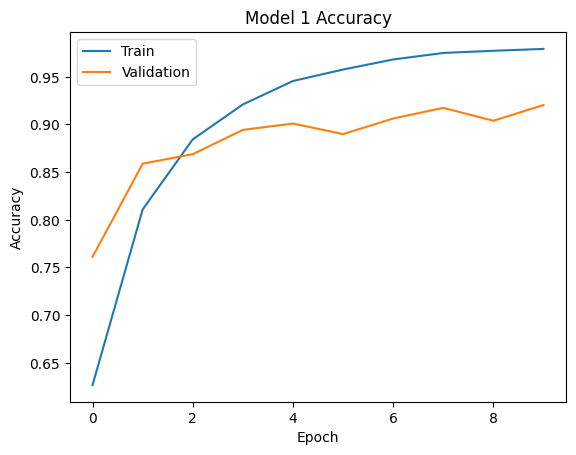

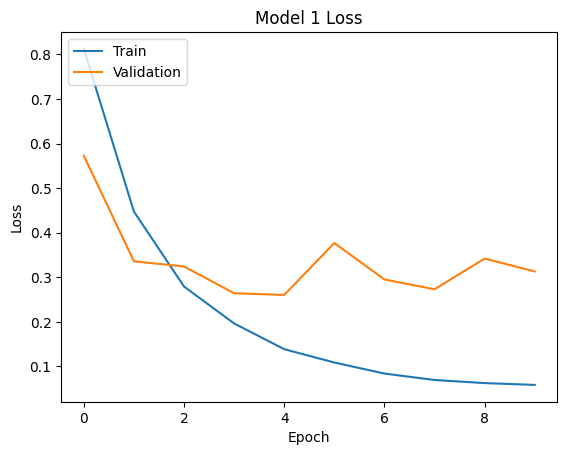

In [46]:
# Evaluate Model 1
print("\nEvaluating Model 1")
predictions_1 = model_1.predict(validation_images)
predicted_classes_1 = np.argmax(predictions_1, axis=1)
# true_classes = validation_images.classes

# Confusion Matrix
cm_1 = confusion_matrix(true_classes, predicted_classes_1)
disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=validation_images.class_indices.keys())
plt.figure(figsize=(8, 8))
disp_1.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Model 1 - Confusion Matrix")
plt.show()

# Classification Report
report_1 = classification_report(true_classes, predicted_classes_1, target_names=validation_images.class_indices.keys())
print("Model 1 - Classification Report:")
print(report_1)

# Accuracy
accuracy_1 = accuracy_score(true_classes, predicted_classes_1)
evaluation_metrics['Model 1'] = {
    'accuracy': accuracy_1,
    'classification_report': report_1,
    'confusion_matrix': cm_1,
    'history': history_1.history
}

# Plot Accuracy and Loss
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model 1 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model 1 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Model 2: CNN + L2 Regularization

In [47]:
# Model 2: CNN + L2 Regularization
print("\nTraining Model 2: CNN + L2 Regularization")
model_2 = models.Sequential()
model_2.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(224, 224, 3)))
model_2.add(layers.BatchNormalization())
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_2.add(layers.BatchNormalization())
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_2.add(layers.BatchNormalization())
model_2.add(layers.MaxPooling2D((2, 2)))

model_2.add(layers.Flatten())
model_2.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_2.add(layers.BatchNormalization())
model_2.add(layers.Dropout(0.5))

model_2.add(layers.Dense(4, activation='softmax'))

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_2 = model_2.fit(train_images, validation_data=validation_images, epochs=10)
histories['Model 2'] = history_2


Training Model 2: CNN + L2 Regularization
Epoch 1/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 2341s 3s/step - accuracy: 0.5253 - loss: 1.8527 - val_accuracy: 0.4126 - val_loss: 3.6788
Epoch 2/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 2236s 3s/step - accuracy: 0.7064 - loss: 1.5113 - val_accuracy: 0.6722 - val_loss: 1.3603
Epoch 3/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 2561s 3s/step - accuracy: 0.7840 - loss: 1.2352 - val_accuracy: 0.3324 - val_loss: 4.5972
Epoch 4/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 3987s 5s/step - accuracy: 0.8216 - loss: 1.2542 - val_accuracy: 0.7610 - val_loss: 1.3439
Epoch 5/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 4304s 5s/step - accuracy: 0.8537 - loss: 1.1471 - val_accuracy: 0.6873 - val_loss: 1.5234
Epoch 6/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 3241s 4s/step - accuracy: 0.8671 - loss: 1.0965 - val_accuracy: 0.8415 - val_loss: 1.2609
Epoch 7/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 2682s 3s/step - accuracy: 0.8817 - loss: 1.0615 - val_accuracy: 0.6164 - val_loss: 1.6660
Epoch 8/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 2308s 3


Evaluating Model 2
213/213 ━━━━━━━━━━━━━━━━━━━━ 123s 573ms/step


<Figure size 800x800 with 0 Axes>

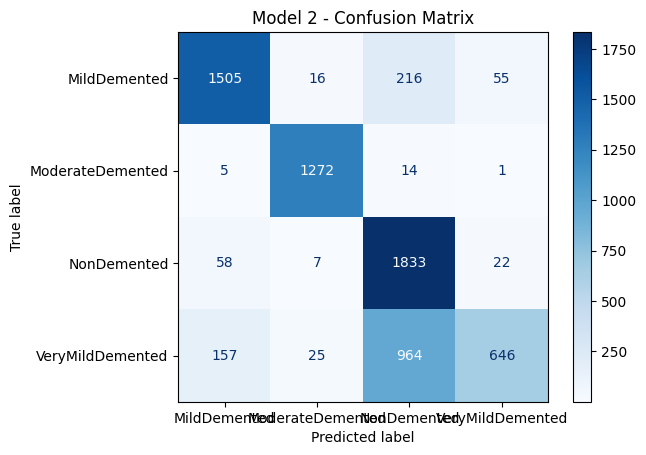

Model 2 - Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.87      0.84      0.86      1792
ModerateDemented       0.96      0.98      0.97      1292
     NonDemented       0.61      0.95      0.74      1920
VeryMildDemented       0.89      0.36      0.51      1792

        accuracy                           0.77      6796
       macro avg       0.83      0.78      0.77      6796
    weighted avg       0.82      0.77      0.76      6796



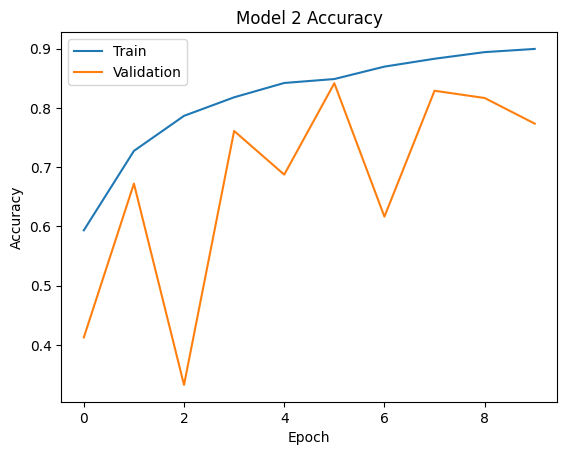

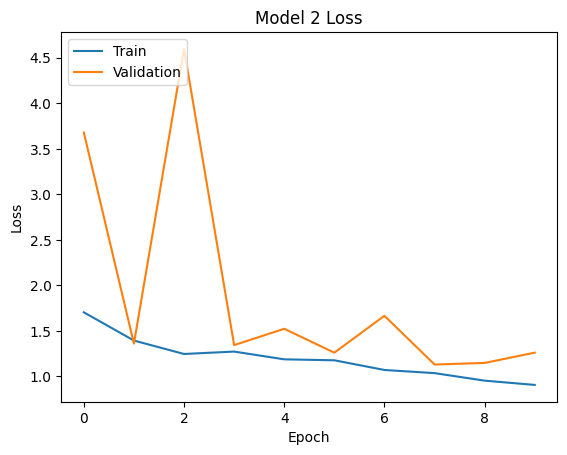

In [48]:
# Evaluate Model 2
print("\nEvaluating Model 2")
predictions_2 = model_2.predict(validation_images)
predicted_classes_2 = np.argmax(predictions_2, axis=1)

# Confusion Matrix
cm_2 = confusion_matrix(true_classes, predicted_classes_2)
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=validation_images.class_indices.keys())
plt.figure(figsize=(8, 8))
disp_2.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Model 2 - Confusion Matrix")
plt.show()

# Classification Report
report_2 = classification_report(true_classes, predicted_classes_2, target_names=validation_images.class_indices.keys())
print("Model 2 - Classification Report:")
print(report_2)

# Accuracy
accuracy_2 = accuracy_score(true_classes, predicted_classes_2)
evaluation_metrics['Model 2'] = {
    'accuracy': accuracy_2,
    'classification_report': report_2,
    'confusion_matrix': cm_2,
    'history': history_2.history
}

# Plot Accuracy and Loss
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model 2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model 2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Model 3: CNN + BatchNormalization

In [ ]:
# Model 3: CNN + BatchNormalization
print("\nTraining Model 3: CNN + BatchNormalization")
model_3 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_3 = model_3.fit(train_images, validation_data=validation_images, epochs=10)
histories['Model 3'] = history_3


Training Model 3: CNN + BatchNormalization
Epoch 1/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 2258s 3s/step - accuracy: 0.5586 - loss: 1.0914 - val_accuracy: 0.6286 - val_loss: 1.0123
Epoch 2/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 2019s 2s/step - accuracy: 0.7518 - loss: 0.6221 - val_accuracy: 0.7830 - val_loss: 0.5623
Epoch 3/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 2964s 3s/step - accuracy: 0.8268 - loss: 0.4529 - val_accuracy: 0.2072 - val_loss: 8.8756
Epoch 4/10
 30/850 ━━━━━━━━━━━━━━━━━━━━ 1:16:34 6s/step - accuracy: 0.8608 - loss: 0.3825

In [ ]:
# Evaluate Model 3
print("\nEvaluating Model 3")
predictions_3 = model_3.predict(validation_images)
predicted_classes_3 = np.argmax(predictions_3, axis=1)

# Confusion Matrix
cm_3 = confusion_matrix(true_classes, predicted_classes_3)
disp_3 = ConfusionMatrixDisplay(confusion_matrix=cm_3, display_labels=validation_images.class_indices.keys())
plt.figure(figsize=(8, 8))
disp_3.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Model 3 - Confusion Matrix")
plt.show()

# Classification Report
report_3 = classification_report(true_classes, predicted_classes_3, target_names=validation_images.class_indices.keys())
print("Model 3 - Classification Report:")
print(report_3)

# Accuracy
accuracy_3 = accuracy_score(true_classes, predicted_classes_3)
evaluation_metrics['Model 3'] = {
    'accuracy': accuracy_3,
    'classification_report': report_3,
    'confusion_matrix': cm_3,
    'history': history_3.history
}

# Plot Accuracy and Loss
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model 3 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Model 3 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Model 4: CNN + L2 + BatchNormalization

In [ ]:
print("\nTraining Model 4: CNN + L2 + BatchNormalization")
model_4 = models.Sequential()
model_4.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(224, 224, 3)))
model_4.add(layers.BatchNormalization())
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_4.add(layers.BatchNormalization())
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_4.add(layers.BatchNormalization())
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Flatten())
model_4.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_4.add(layers.BatchNormalization())
model_4.add(layers.Dropout(0.5))
model_4.add(layers.Dense(4, activation='softmax'))
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_4 = model_4.fit(train_images, validation_data=validation_images, epochs=10)
histories['Model 4'] = history_4

In [ ]:
# Evaluate Model 4
print("\nEvaluating Model 4")
predictions_4 = model_4.predict(validation_images)
predicted_classes_4 = np.argmax(predictions_4, axis=1)

# Confusion Matrix
cm_4 = confusion_matrix(true_classes, predicted_classes_4)
disp_4 = ConfusionMatrixDisplay(confusion_matrix=cm_4, display_labels=validation_images.class_indices.keys())
plt.figure(figsize=(8, 8))
disp_4.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Model 4 - Confusion Matrix")
plt.show()

# Classification Report
report_4 = classification_report(true_classes, predicted_classes_4, target_names=validation_images.class_indices.keys())
print("Model 4 - Classification Report:")
print(report_4)

# Accuracy
accuracy_4 = accuracy_score(true_classes, predicted_classes_4)
evaluation_metrics['Model 4'] = {
    'accuracy': accuracy_4,
    'classification_report': report_4,
    'confusion_matrix': cm_4,
    'history': history_4.history
}

# Plot Accuracy and Loss
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('Model 4 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('Model 4 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Model 5: CNN + Dropout

In [ ]:
print("\nTraining Model 5: CNN + Dropout")
model_5 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])
model_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_5 = model_5.fit(train_images, validation_data=validation_images, epochs=10)
histories['Model 5'] = history_5

In [ ]:
# Evaluate Model 5
print("\nEvaluating Model 5")
predictions_5 = model_5.predict(validation_images)
predicted_classes_5 = np.argmax(predictions_5, axis=1)

# Confusion Matrix
cm_5 = confusion_matrix(true_classes, predicted_classes_5)
disp_5 = ConfusionMatrixDisplay(confusion_matrix=cm_5, display_labels=validation_images.class_indices.keys())
plt.figure(figsize=(8, 8))
disp_5.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Model 5 - Confusion Matrix")
plt.show()

# Classification Report
report_5 = classification_report(true_classes, predicted_classes_5, target_names=validation_images.class_indices.keys())
print("Model 5 - Classification Report:")
print(report_5)

# Accuracy
accuracy_5 = accuracy_score(true_classes, predicted_classes_5)
evaluation_metrics['Model 5'] = {
    'accuracy': accuracy_5,
    'classification_report': report_5,
    'confusion_matrix': cm_5,
    'history': history_5.history
}

# Plot Accuracy and Loss
plt.plot(history_5.history['accuracy'])
plt.plot(history_5.history['val_accuracy'])
plt.title('Model 5 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.title('Model 5 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Model 6: CNN + EarlyStopping

In [ ]:
print("\nTraining Model 6: CNN + EarlyStopping")
model_6 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])
model_6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping_6 = EarlyStopping(monitor='val_loss', patience=3)
history_6 = model_6.fit(train_images, validation_data=validation_images, epochs=10, callbacks=[early_stopping_6])
histories['Model 6'] = history_6

In [ ]:
# Evaluate Model 6
print("\nEvaluating Model 6")
predictions_6 = model_6.predict(validation_images)
predicted_classes_6 = np.argmax(predictions_6, axis=1)

# Confusion Matrix
cm_6 = confusion_matrix(true_classes, predicted_classes_6)
disp_6 = ConfusionMatrixDisplay(confusion_matrix=cm_6, display_labels=validation_images.class_indices.keys())
plt.figure(figsize=(8, 8))
disp_6.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Model 6 - Confusion Matrix")
plt.show()

# Classification Report
report_6 = classification_report(true_classes, predicted_classes_6, target_names=validation_images.class_indices.keys())
print("Model 6 - Classification Report:")
print(report_6)

# Accuracy
accuracy_6 = accuracy_score(true_classes, predicted_classes_6)
evaluation_metrics['Model 6'] = {
    'accuracy': accuracy_6,
    'classification_report': report_6,
    'confusion_matrix': cm_6,
    'history': history_6.history
}

# Plot Accuracy and Loss
plt.plot(history_6.history['accuracy'])
plt.plot(history_6.history['val_accuracy'])
plt.title('Model 6 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_6.history['loss'])
plt.plot(history_6.history['val_loss'])
plt.title('Model 6 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Model 7: CNN + ReduceLROnPlateau

In [ ]:
print("\nTraining Model 7: CNN + ReduceLROnPlateau")
model_7 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])
model_7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr_7 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
history_7 = model_7.fit(train_images, validation_data=validation_images, epochs=10, callbacks=[reduce_lr_7])
histories['Model 7'] = history_7

In [ ]:
# Evaluate Model 7
print("\nEvaluating Model 7")
predictions_7 = model_7.predict(validation_images)
predicted_classes_7 = np.argmax(predictions_7, axis=1)

# Confusion Matrix
cm_7 = confusion_matrix(true_classes, predicted_classes_7)
disp_7 = ConfusionMatrixDisplay(confusion_matrix=cm_7, display_labels=validation_images.class_indices.keys())
plt.figure(figsize=(8, 8))
disp_7.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Model 7 - Confusion Matrix")
plt.show()

# Classification Report
report_7 = classification_report(true_classes, predicted_classes_7, target_names=validation_images.class_indices.keys())
print("Model 7 - Classification Report:")
print(report_7)

# Accuracy
accuracy_7 = accuracy_score(true_classes, predicted_classes_7)
evaluation_metrics['Model 7'] = {
    'accuracy': accuracy_7,
    'classification_report': report_7,
    'confusion_matrix': cm_7,
    'history': history_7.history
}

# Plot Accuracy and Loss
plt.plot(history_7.history['accuracy'])
plt.plot(history_7.history['val_accuracy'])
plt.title('Model 7 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_7.history['loss'])
plt.plot(history_7.history['val_loss'])
plt.title('Model 7 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Model 9 (OG)

In [ ]:
# Model 9 (Original)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D

# model architecture
model_9 = tf.keras.models.Sequential([
    Conv2D(16, (3,3), activation = 'relu', input_shape = (224,224, 3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation = 'relu'), #  fully connected layer with 512 units
    Dropout(0.2), # drops 20% of the neurons in this layer during training
    Dense(4, activation = 'softmax') # softmax for multi class
])

model_9.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])
history_9 = model_9.fit(train_images,
    steps_per_epoch=len(train_images),
    validation_data=validation_images,
    validation_steps=len(validation_images),
    epochs=10)

histories['Model 9'] = history_9

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 32)        0

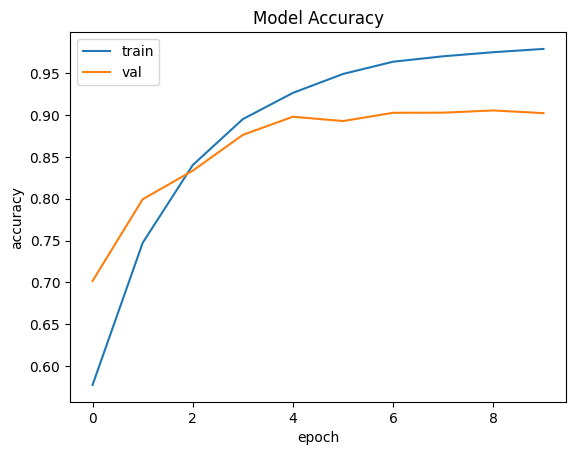

In [ ]:
#Accuracy
plt.plot(history_9.history['accuracy'])
plt.plot(history_9.history['val_accuracy'])
plt.title('Model 9 Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# loss
plt.plot(history_9.history['loss'])
plt.plot(history_9.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Make predictions on validation data
# Since validation_images is a generator, we can use `predict` on the entire validation set
predictions_9 = model_9.predict(validation_images)
predicted_classes_9 = np.argmax(predictions_9, axis=1)  # Convert probabilities to class indices

# 2. Get true labels from validation data generator
#true_classes = validation_images.classes  # Original labels for the validation set

# 3. Generate the confusion matrix
cm_9 = confusion_matrix(true_classes, predicted_classes_9)
disp_9 = ConfusionMatrixDisplay(confusion_matrix=cm_9, display_labels=validation_images.class_indices.keys())

# 4. Plot the confusion matrix
plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Model 9 - Confusion Matrix")
plt.show()

import numpy as np
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Get Predictions on Validation Data
predictions = model.predict(validation_images)
predicted_classes = np.argmax(predictions, axis=1)

# Get True Labels from Validation Data
#true_classes = validation_images.classes

# Generate a Classification Report
report = classification_report(true_classes, predicted_classes, target_names=validation_images.class_indices.keys())
print("Classification Report:")
print(report)

# Calculate Overall Accuracy (as an additional check)
accuracy = accuracy_score(true_classes, predicted_classes)
print("Overall Accuracy:", accuracy)

# Model 10: CNN + L2 + EarlyStopping + BatchNormalization

In [ ]:
# Model 10: CNN + L2 + EarlyStopping + BatchNormalization
print("\nTraining Model 10: CNN + L2 + EarlyStopping + BatchNormalization")
early_stopping_10 = EarlyStopping(monitor='val_loss', patience=3)

model_10 = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    # Convolutional layers with L2 regularization
    layers.Conv2D(32, (3, 3), activation=None,
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation=None,
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation=None,
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation=None,
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.ReLU(),

    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

model_10.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

history_10 = model_10.fit(
    train_images,
    epochs=10,
    validation_data=validation_images,
    callbacks=[early_stopping_10]
)
histories['Model 10'] = history_10

In [ ]:
# Evaluate Model 10
print("\nEvaluating Model 10")
predictions_10 = model_10.predict(validation_images)
predicted_classes_10 = np.argmax(predictions_10, axis=1)

# Confusion Matrix
cm_10 = confusion_matrix(true_classes, predicted_classes_10)
disp_10 = ConfusionMatrixDisplay(confusion_matrix=cm_10, display_labels=validation_images.class_indices.keys())
plt.figure(figsize=(8, 8))
disp_10.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Model 10 - Confusion Matrix")
plt.show()

# Classification Report
report_10 = classification_report(true_classes, predicted_classes_10, target_names=validation_images.class_indices.keys())
print("Model 10 - Classification Report:")
print(report_10)

# Accuracy
accuracy_10 = accuracy_score(true_classes, predicted_classes_10)
evaluation_metrics['Model 10'] = {
    'accuracy': accuracy_10,
    'classification_report': report_10,
    'confusion_matrix': cm_10,
    'history': history_10.history
}

# Plot Accuracy and Loss
plt.plot(history_10.history['accuracy'])
plt.plot(history_10.history['val_accuracy'])
plt.title('Model 10 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_10.history['loss'])
plt.plot(history_10.history['val_loss'])
plt.title('Model 10 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Model 11: Pre-trained ResNet50

In [ ]:
# Model 11: Pre-trained ResNet50
print("\nTraining Model 11: Pre-trained ResNet50")
from tensorflow.keras.applications import ResNet50

# Load the pre-trained ResNet50 model without the top classification layer
base_model_11 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
base_model_11.trainable = False

# Build the custom model
model_11 = models.Sequential([
    base_model_11,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # Output layer for 4 classes
])

# Compile the model
model_11.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train Model 11
history_11 = model_11.fit(
    train_images,
    epochs=10,
    validation_data=validation_images
)
histories['Model 11'] = history_11

In [ ]:
# Evaluate Model 11
print("\nEvaluating Model 11")
predictions_11 = model_11.predict(validation_images)
predicted_classes_11 = np.argmax(predictions_11, axis=1)

# Confusion Matrix
cm_11 = confusion_matrix(true_classes, predicted_classes_11)
disp_11 = ConfusionMatrixDisplay(confusion_matrix=cm_11, display_labels=validation_images.class_indices.keys())
plt.figure(figsize=(8, 8))
disp_11.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Model 11 - Confusion Matrix")
plt.show()

# Classification Report
report_11 = classification_report(true_classes, predicted_classes_11, target_names=validation_images.class_indices.keys())
print("Model 11 - Classification Report:")
print(report_11)

# Accuracy
accuracy_11 = accuracy_score(true_classes, predicted_classes_11)
evaluation_metrics['Model 11'] = {
    'accuracy': accuracy_11,
    'classification_report': report_11,
    'confusion_matrix': cm_11,
    'history': history_11.history
}

# Plot Accuracy and Loss
plt.plot(history_11.history['accuracy'])
plt.plot(history_11.history['val_accuracy'])
plt.title('Model 11 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_11.history['loss'])
plt.plot(history_11.history['val_loss'])
plt.title('Model 11 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluating All

In [ ]:
model_names = list(evaluation_metrics.keys())
accuracies = [evaluation_metrics[model]['accuracy'] for model in model_names]
val_accuracies = [histories[model].history['val_accuracy'][-1] for model in model_names]
val_losses = [histories[model].history['val_loss'][-1] for model in model_names]

# Plotting the comparison
plt.figure(figsize=(12, 6))
plt.bar(model_names, accuracies)
plt.title('Overall Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(model_names, val_accuracies)
plt.title('Validation Accuracy Comparison')
plt.ylabel('Validation Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(model_names, val_losses)
plt.title('Validation Loss Comparison')
plt.ylabel('Validation Loss')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()